In [1]:
import numpy as np
import cv2
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import glob
import os
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.cluster import KMeans

In [2]:
os.listdir("../input/tomato/dataset/")

['val', 'train']

In [3]:
fruit_images = []
labels = [] 
for fruit_dir_path in glob.glob("../input/tomato/dataset/train/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.JPG")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [4]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [5]:
id_to_label_dict


{0: 'Bacterial_spot',
 1: 'Early_blight',
 2: 'Late_blight',
 3: 'Leaf_Mold',
 4: 'Septoria_leaf_spot',
 5: 'Spider_mites Two-spotted_spider_mite',
 6: 'Target_Spot',
 7: 'Tomato_Yellow_Leaf_Curl_Virus',
 8: 'Tomato_mosaic_virus',
 9: 'healthy'}

In [6]:
label_ids = np.array([label_to_id_dict[x] for x in labels])


In [7]:
def plot_image_grid(images, nb_rows, nb_cols, figsize=(5, 5)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            # axs[i, j].xaxis.set_ticklabels([])
            # axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1    

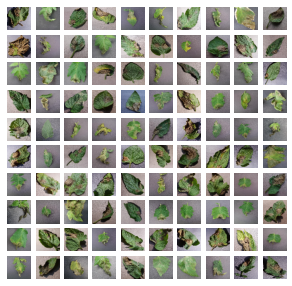

In [8]:
plot_image_grid(fruit_images[0:100], 10, 10)


In [9]:
scaler = StandardScaler()


In [10]:
images_scaled = scaler.fit_transform([i.flatten() for i in fruit_images])


In [11]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(images_scaled)

In [12]:
tsne = TSNE(n_components=2, perplexity=40.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

In [13]:
def visualize_scatter(data_2d, label_ids, id_to_label_dict=None, figsize=(20,20)):
    if not id_to_label_dict:
        id_to_label_dict = {v:i for i,v in enumerate(np.unique(label_ids))}
    
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    cmap = plt.cm.get_cmap("jet", nb_classes)
    
    for i, label_id in enumerate(np.unique(label_ids)):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    c= cmap(i),
                    linewidth='5',
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    #plt.legend(loc='best')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),
          fancybox=True, shadow=True, ncol=1, fontsize=figsize[0])

In [14]:
def visualize_scatter_with_images(data_2d, images, figsize=(45,45), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    plt.grid()
    artists = []
    for xy, i in zip(data_2d, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(data_2d)
    ax.autoscale()
    plt.show()

In [15]:
visualize_scatter(tsne_result_scaled, label_ids, id_to_label_dict, figsize=(25, 25))


TypeError: must be real number, not str

<Figure size 1800x1800 with 1 Axes>

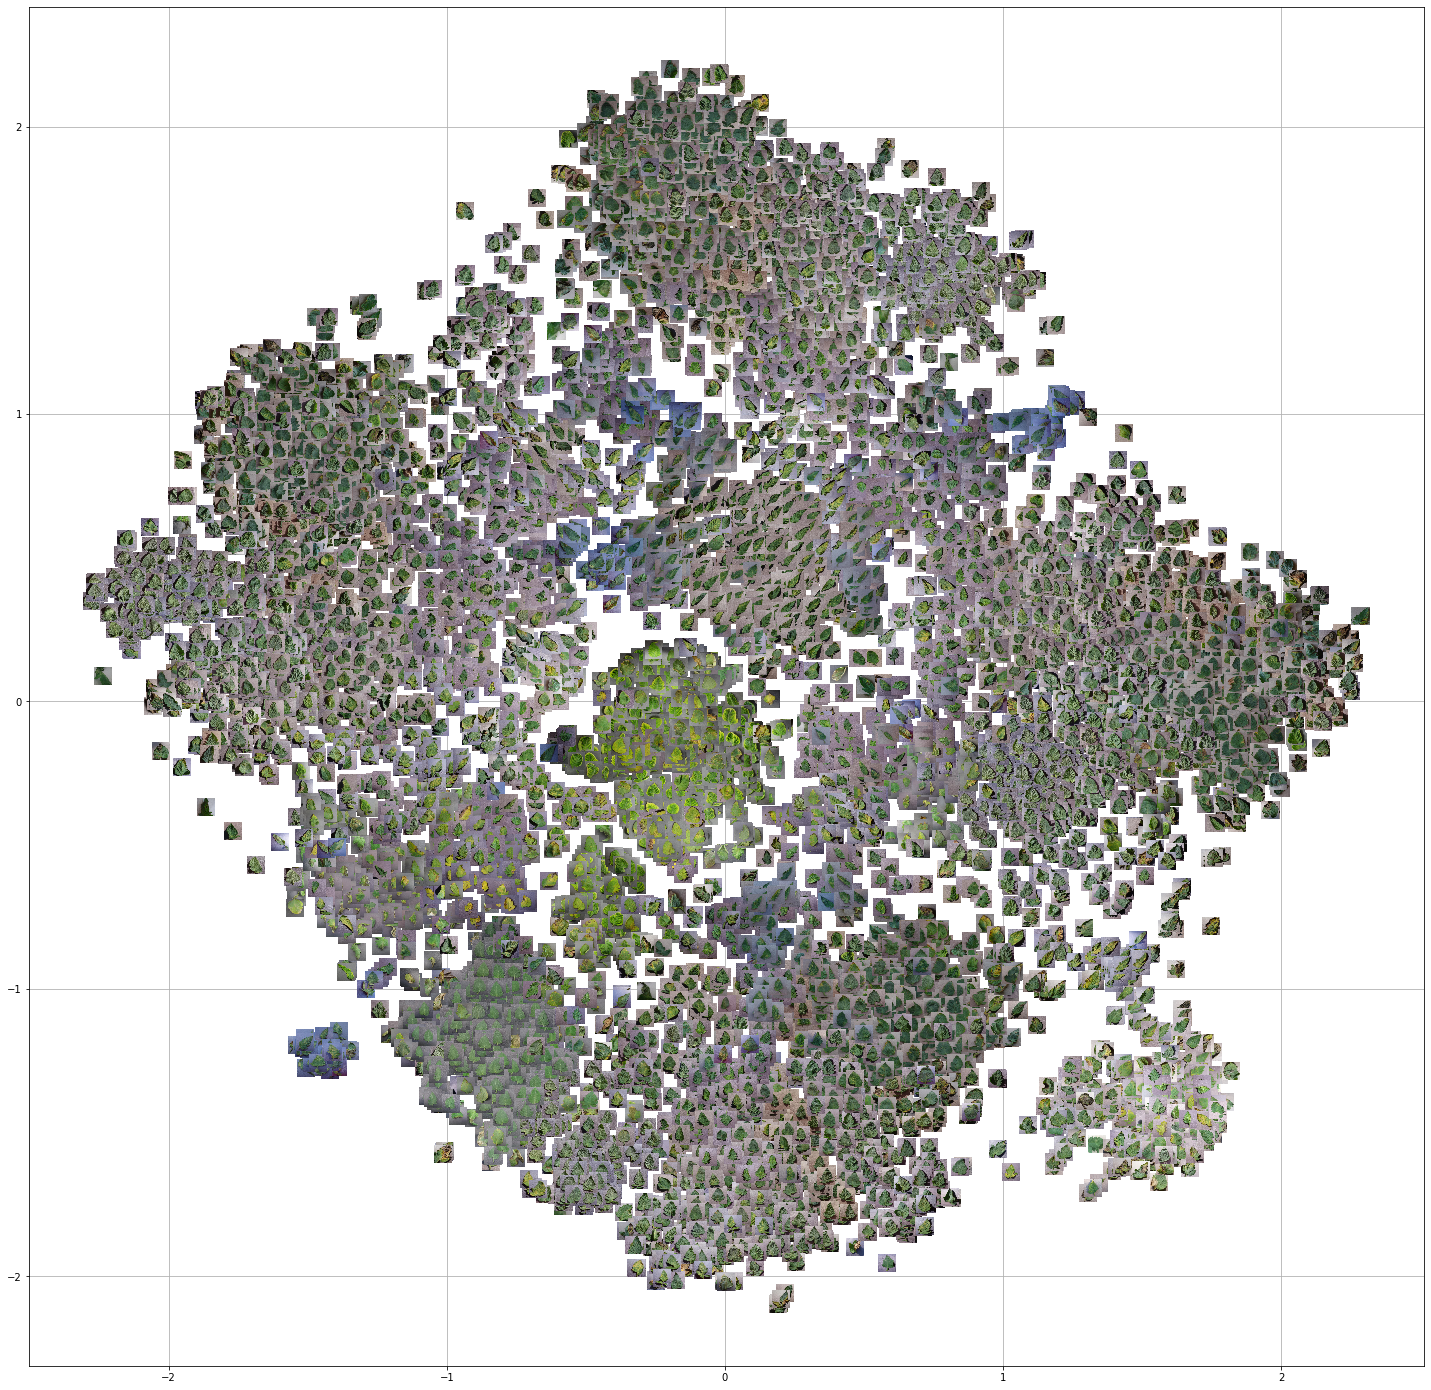

In [16]:
visualize_scatter_with_images(tsne_result_scaled, fruit_images, image_zoom=0.4, figsize=(25, 25))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, label_ids, test_size=0.25, random_state=42)

In [18]:
forest = RandomForestClassifier(n_estimators=10)
forest = forest.fit(X_train, y_train)

In [19]:
test_predictions = forest.predict(X_test)

In [20]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with RandomForest: {0:.6f}".format(precision))

Accuracy with RandomForest: 59.765940


In [21]:
svm_clf = svm.SVC()
svm_clf = svm_clf.fit(X_train, y_train) 

In [22]:
precision = accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM: {0:.6f}".format(precision))

Accuracy with SVM: 59.765940


In [23]:
validation_fruit_images = []
validation_labels = [] 
for fruit_dir_path in glob.glob("../input/tomato/dataset/val/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.JPG")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.resize(image, (45, 45))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [24]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])


In [25]:
validation_images_scaled = scaler.transform([i.flatten() for i in validation_fruit_images])


In [26]:
validation_pca_result = pca.transform(validation_images_scaled)


In [27]:
test_predictions = forest.predict(validation_pca_result)


In [28]:
precision = accuracy_score(test_predictions, validation_label_ids) * 100
print("Validation Accuracy with Random Forest: {0:.6f}".format(precision))

Validation Accuracy with Random Forest: 55.276382


In [29]:
test_predictions = svm_clf.predict(validation_pca_result)


In [30]:
precision = accuracy_score(test_predictions, validation_label_ids) * 100
print("Validation Accuracy with SVM: {0:.6f}".format(precision))

Validation Accuracy with SVM: 75.979899
